# Important Library Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import math
from torchvision.utils import make_grid
import time
import pickle
import torch.nn.functional

# Helper Functions

In [3]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# Load and Augment Dataset

In [4]:
# Create Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.ToTensor()
])

# transforms.RandomApply([
#             transforms.ElasticTransform(alpha=40.0, sigma=8.0)
#         ], p=0.2),
#         transforms.RandomApply([
#             transforms.RandomAffine(degrees=0, shear=20, fill=255)
#         ], p=0.2),


# Load Training, Validation, and Testing Images
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 64
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Running on {DEVICE}")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Running on cuda


# Construct Student

In [5]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()

        conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1).to(DEVICE)
        relu1 = nn.LeakyReLU().to(DEVICE)
        pool1 = nn.MaxPool2d(kernel_size=2).to(DEVICE)

        conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1).to(DEVICE)
        relu2 = nn.LeakyReLU().to(DEVICE)
        pool2 = nn.MaxPool2d(kernel_size=2).to(DEVICE)

        conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1).to(DEVICE)
        relu3 = nn.LeakyReLU().to(DEVICE)
        Apool = nn.AdaptiveAvgPool2d(1).to(DEVICE)
        
        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(128, 38).to(DEVICE)
        # softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, pool1, conv2, relu2, pool2, conv3, relu3, Apool, flatten, fcn1).to(DEVICE)

    def forward(self, x):
        return self.layers(x).to(DEVICE)

def distillation_loss(student_pred, teacher_pred, labels, T, alpha):
    # Calculate soft targets
    soft_loss = nn.functional.kl_div(nn.functional.log_softmax(student_pred / T, dim=1), nn.functional.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T * T)

    # Calculate soft targets
    criterion = nn.CrossEntropyLoss()
    hard_loss = criterion(student_pred, labels)

    # Calculate total loss
    loss = alpha * hard_loss + (1 - alpha) * soft_loss

    return loss

# Train Student

In [18]:
from DiseasedCNN import DiseasedCNN
CONTINUE_TRAINING = True
NUM_EPOCHS = 25

# Load teacher
teacher = DiseasedCNN()
teacher.load_state_dict(torch.load('finalmodelinfo/DiseasedCNN/DiseasedCNN_statedict.pth'))
teacher.layers[-1] = nn.Identity()
teacher.eval().to(DEVICE)


# Init hyperparameters
learning_rate = 0.0005
adam_beta1 = 0.9
adam_beta2 = 0.999
T = 4
ALPHA = 0.7
# Create student
student = StudentModel()
student.train()
optimizer = torch.optim.Adam(params=student.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epoch_loss = []
validation_acc = []
start_epoch = 0

# For picking up training later
if CONTINUE_TRAINING:
    checkpoint = torch.load("studentmodel_85_optimizer_state.pth")
    student.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    student.train()

    file_path = "finalmodelinfo/StudentModel/StudentModel_training_info.pickle"
    with open(file_path, "rb") as file:
        loaded = pickle.load(file)
        epoch_loss = loaded["epoch_loss"]
        validation_acc = loaded["validation_acc"]
# For picking up training later


student.to(DEVICE)
for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    train_loss = []
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        student_pred = student(batch)

        with torch.no_grad():
            teacher_pred = teacher(batch)

        loss = distillation_loss(student_pred, teacher_pred, labels, T, ALPHA)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss.append(loss.item())

    # Perform validation and store accuracy
    validation_accuracy = validate_model(student, val_loader, DEVICE)
    validation_acc.append(validation_accuracy)
    print(validation_accuracy)

    # print(test_model(student, train_loader, DEVICE))

    if epoch != 0 and epoch % 10 == 0:
        scheduler.step()

    # Track average loss for each epoch
    print(sum(train_loss) / len(train_loss))
    epoch_loss.append(sum(train_loss) / len(train_loss))

Epoch: 75
85.50665021253256
3.089153903749098
Epoch: 76
86.21966269025091
3.0750286752942384
Epoch: 77
86.32935691759222
3.042932108154353
Epoch: 78
84.8347730700672
3.013828716151669
Epoch: 79
86.05512134923899
2.999382193379971
Epoch: 80
86.85040449746332
2.972132613451737
Epoch: 81
87.3851638557521
2.9271204366248558
Epoch: 82
86.05512134923899
2.9267002767245445
Epoch: 83
86.76813382695737
2.8889867894252728
Epoch: 84
86.54874537227478
2.874714127872057
Epoch: 85
86.68586315645139
2.860667612134796
Epoch: 86
87.31660496366379
2.8591953745997882
Epoch: 87
87.31660496366379
2.8086272579931895
Epoch: 88
87.96105854929385
2.793495164001813
Epoch: 89
86.69957493486905
2.7855536094996998
Epoch: 90
86.85040449746332
2.7616917210931455
Epoch: 91
87.5222816399287
2.7472983702293026
Epoch: 92
87.50856986151105
2.7252415481828627
Epoch: 93
86.98752228163993
2.710502304806098
Epoch: 94
87.08350473056356
2.6914799374052283
Epoch: 95
87.61826408885233
2.6859372878812025
Epoch: 96
88.166735225558

### Plot Loss

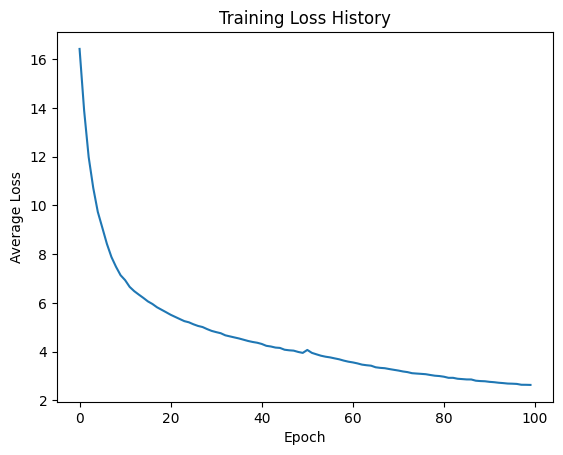

In [19]:
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.savefig("finalmodelinfo/StudentModel/StudentModel_TrainingLoss")
plt.show()

### Plot Validation Accuracy

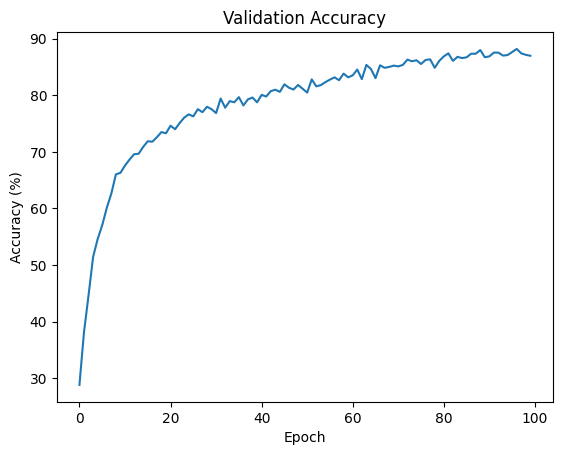

In [26]:
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(validation_acc)
plt.savefig("finalmodelinfo/StudentModel/StudentModel_ValAcc")
plt.show()

# Test Model

In [21]:
accuracy = test_model(model=student, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

Model accuracy: 86.406951


### Save Model

##### Save Full Model

In [22]:
torch.save(student, 'finalmodelinfo/StudentModel/StudentModel.pth')

##### Save Model State Dict

In [23]:
torch.save(student.state_dict(), "finalmodelinfo/StudentModel/StudentModel_statedict.pth")

##### Save Optimizer State

In [24]:
torch.save({
    'epoch': epoch,
    'model_state_dict': student.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "studentmodel_XX_optimizer_state.pth")

##### Save Training Info

In [25]:
file_path = "finalmodelinfo/StudentModel/StudentModel_training_info.pickle"
info = {}
info["epoch_loss"] = epoch_loss
info["validation_acc"] = validation_acc
with open(file_path, "wb") as file:
    pickle.dump(info, file)